# Imports

In [1]:
from fastai.imports import *
from fastai.structured import *
from fastai.column_data import *
from torch.nn import functional as F
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

/home/zero/anaconda/envs/fastai-cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/zero/anaconda/envs/fastai-cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/zero/anaconda/envs/fastai-cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
import gc
import pdb

In [3]:
def proc_df2(df, y_fld = None, skip_flds=None, do_scale=True, na_dict=None,
             preproc_fn=None, max_n_cat=10, subset=None, mapper=None):
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    df = df.copy()
    if preproc_fn: preproc_fn(df)
    if y_fld is not None: 
        y = df[y_fld].values
        df.drop(skip_flds+[y_fld], axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    if y_fld is not None: 
        res = [pd.get_dummies(df, dummy_na=True), y, na_dict]
    else:
        res = [pd.get_dummies(df, dummy_na=True), na_dict]
    if do_scale: res = res + [mapper]
    return res

In [4]:
df_train = pd.read_csv('data/application_train.csv')
train_cats(df_train)

In [5]:
y_label = df_train['TARGET'].values

In [6]:
df_train = df_train.drop(columns = ['TARGET', 'SK_ID_CURR'])

In [7]:
x_train,x_valid, y_train, y_valid = train_test_split(df_train, y_label, test_size=0.25, stratify = y_label)

In [8]:
train_proc, train_na, mapper = proc_df2(x_train)

In [9]:
valid_proc, valid_na, _ =  proc_df2(x_valid, na_dict = train_na, mapper= mapper)

In [10]:
del df_train, y_label, x_train, x_valid; gc.collect()

154

# categorical variables

In [11]:
cat_vars = [col for col in train_proc if train_proc[col].dtype.name != 'float64' and train_proc[col].dtype.name != 'float32' and len(train_proc[col].unique()) < 150]

In [12]:
len(cat_vars)

80

In [13]:
cat_vars

['OCCUPATION_TYPE',
 'ORGANIZATION_TYPE',
 'NAME_CONTRACT_TYPE_Cash loans',
 'NAME_CONTRACT_TYPE_Revolving loans',
 'NAME_CONTRACT_TYPE_nan',
 'CODE_GENDER_F',
 'CODE_GENDER_M',
 'CODE_GENDER_XNA',
 'CODE_GENDER_nan',
 'FLAG_OWN_CAR_N',
 'FLAG_OWN_CAR_Y',
 'FLAG_OWN_CAR_nan',
 'FLAG_OWN_REALTY_N',
 'FLAG_OWN_REALTY_Y',
 'FLAG_OWN_REALTY_nan',
 'NAME_TYPE_SUITE_Children',
 'NAME_TYPE_SUITE_Family',
 'NAME_TYPE_SUITE_Group of people',
 'NAME_TYPE_SUITE_Other_A',
 'NAME_TYPE_SUITE_Other_B',
 'NAME_TYPE_SUITE_Spouse, partner',
 'NAME_TYPE_SUITE_Unaccompanied',
 'NAME_TYPE_SUITE_nan',
 'NAME_INCOME_TYPE_Businessman',
 'NAME_INCOME_TYPE_Commercial associate',
 'NAME_INCOME_TYPE_Maternity leave',
 'NAME_INCOME_TYPE_Pensioner',
 'NAME_INCOME_TYPE_State servant',
 'NAME_INCOME_TYPE_Student',
 'NAME_INCOME_TYPE_Unemployed',
 'NAME_INCOME_TYPE_Working',
 'NAME_INCOME_TYPE_nan',
 'NAME_EDUCATION_TYPE_Academic degree',
 'NAME_EDUCATION_TYPE_Higher education',
 'NAME_EDUCATION_TYPE_Incomplete higher

In [14]:
cat_sz = [(c, len(train_proc[c].unique())+1) for c in cat_vars] #list of categorical variable and number of unq value

In [15]:
cat_sz

[('OCCUPATION_TYPE', 20),
 ('ORGANIZATION_TYPE', 59),
 ('NAME_CONTRACT_TYPE_Cash loans', 3),
 ('NAME_CONTRACT_TYPE_Revolving loans', 3),
 ('NAME_CONTRACT_TYPE_nan', 2),
 ('CODE_GENDER_F', 3),
 ('CODE_GENDER_M', 3),
 ('CODE_GENDER_XNA', 3),
 ('CODE_GENDER_nan', 2),
 ('FLAG_OWN_CAR_N', 3),
 ('FLAG_OWN_CAR_Y', 3),
 ('FLAG_OWN_CAR_nan', 2),
 ('FLAG_OWN_REALTY_N', 3),
 ('FLAG_OWN_REALTY_Y', 3),
 ('FLAG_OWN_REALTY_nan', 2),
 ('NAME_TYPE_SUITE_Children', 3),
 ('NAME_TYPE_SUITE_Family', 3),
 ('NAME_TYPE_SUITE_Group of people', 3),
 ('NAME_TYPE_SUITE_Other_A', 3),
 ('NAME_TYPE_SUITE_Other_B', 3),
 ('NAME_TYPE_SUITE_Spouse, partner', 3),
 ('NAME_TYPE_SUITE_Unaccompanied', 3),
 ('NAME_TYPE_SUITE_nan', 3),
 ('NAME_INCOME_TYPE_Businessman', 3),
 ('NAME_INCOME_TYPE_Commercial associate', 3),
 ('NAME_INCOME_TYPE_Maternity leave', 3),
 ('NAME_INCOME_TYPE_Pensioner', 3),
 ('NAME_INCOME_TYPE_State servant', 3),
 ('NAME_INCOME_TYPE_Student', 3),
 ('NAME_INCOME_TYPE_Unemployed', 3),
 ('NAME_INCOME_TYPE_Wo

In [16]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz] #number of unique value and embedding size for each cat vars

In [17]:
sum([j[1] for j in emb_szs])

186

In [18]:
for i,j in zip(cat_sz, emb_szs): print(i[0], ': num unique value: ', j[0], ', embedding size: ', j[1], sep = '')

OCCUPATION_TYPE: num unique value: 20, embedding size: 10
ORGANIZATION_TYPE: num unique value: 59, embedding size: 30
NAME_CONTRACT_TYPE_Cash loans: num unique value: 3, embedding size: 2
NAME_CONTRACT_TYPE_Revolving loans: num unique value: 3, embedding size: 2
NAME_CONTRACT_TYPE_nan: num unique value: 2, embedding size: 1
CODE_GENDER_F: num unique value: 3, embedding size: 2
CODE_GENDER_M: num unique value: 3, embedding size: 2
CODE_GENDER_XNA: num unique value: 3, embedding size: 2
CODE_GENDER_nan: num unique value: 2, embedding size: 1
FLAG_OWN_CAR_N: num unique value: 3, embedding size: 2
FLAG_OWN_CAR_Y: num unique value: 3, embedding size: 2
FLAG_OWN_CAR_nan: num unique value: 2, embedding size: 1
FLAG_OWN_REALTY_N: num unique value: 3, embedding size: 2
FLAG_OWN_REALTY_Y: num unique value: 3, embedding size: 2
FLAG_OWN_REALTY_nan: num unique value: 2, embedding size: 1
NAME_TYPE_SUITE_Children: num unique value: 3, embedding size: 2
NAME_TYPE_SUITE_Family: num unique value: 3, e

# model data loader

In [22]:
bs = 16

In [23]:
PATH = './'

In [37]:
md  = ColumnarModelData.from_data_frames(PATH, 
                                         trn_df = train_proc, val_df = valid_proc, 
                                         trn_y = y_train.astype('int'), val_y = y_valid.astype('int'), 
                                         cat_flds=cat_vars, bs=bs, is_reg= False, is_multi = True)

## inside data loader

In [204]:
train_proc[cat_vars].head(5)

,OCCUPATION_TYPE,ORGANIZATION_TYPE,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_nan,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,CODE_GENDER_nan,FLAG_OWN_CAR_N,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,WALLSMATERIAL_MODE_nan,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,EMERGENCYSTATE_MODE_nan
18612,17,12,1,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
298378,9,27,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0
91432,0,58,1,0,0,0,1,0,0,1,...,0,0,0,1,0,0,0,1,0,0
22692,15,34,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
124933,0,58,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [38]:
a = md.trn_dl

In [28]:
it = iter(md.trn_dl)

In [203]:
*x, y = next(it)

In [254]:
x[0].size()

torch.Size([16, 80])

In [255]:
x[1].size()

torch.Size([16, 165])

In [205]:
x[0][:5,:]



Columns 0 to 12 
    5     8     1     0     0     0     1     0     0     0     1     0     0
    4     3     0     1     0     1     0     0     0     1     0     0     0
   15     8     1     0     0     1     0     0     0     1     0     0     0
    5    43     1     0     0     1     0     0     0     0     1     0     1
    9    15     1     0     0     0     1     0     0     1     0     0     1

Columns 13 to 25 
    1     0     0     0     0     0     0     0     1     0     0     0     0
    1     0     0     0     0     0     0     0     1     0     0     1     0
    1     0     0     1     0     0     0     0     0     0     0     0     0
    0     0     0     1     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     1     0     0     0     0

Columns 26 to 38 
    0     0     0     0     1     0     0     0     0     0     1     0     0
    0     0     0     0     0     0     0     1     0     0     0     0     0
    0  

In [206]:
y


 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
[torch.cuda.LongTensor of size 16 (GPU 0)]

# model

In [207]:
class tabular_model(nn.Module):
    def __init__(self, emb_szs, n_cont, emb_drop, szs, drops):
        
        super().__init__()
        self.embs = nn.ModuleList([nn.Embedding(c, s) for c,s in emb_szs])
        for emb in self.embs: emb_init(emb)
        n_emb = sum(e.embedding_dim for e in self.embs)
        self.n_emb, self.n_cont=n_emb, n_cont
        
        szs = [n_emb+n_cont] + szs
        self.lins = nn.ModuleList([nn.Linear(szs[i], szs[i+1]) for i in range(len(szs)-1)])
        self.bns = nn.ModuleList([nn.BatchNorm1d(sz) for sz in szs[1:]])
        for o in self.lins: kaiming_normal(o.weight.data)
        self.outp = nn.Linear(szs[-1], 1)
        kaiming_normal(self.outp.weight.data)

        self.emb_drop = nn.Dropout(emb_drop)
        self.drops = nn.ModuleList([nn.Dropout(drop) for drop in drops])
        self.bn = nn.BatchNorm1d(n_cont)

    def forward(self, x_cat, x_cont):
        
        #cat vars
        x = [e(x_cat[:,i]) for i,e in enumerate(self.embs)]
        x = torch.cat(x, 1)
        x = self.emb_drop(x)
        
        #con vars
        x2 = self.bn(x_cont)
        x = torch.cat([x, x2], 1)
        
        for linear,drop_out,batch_norm in zip(self.lins, self.drops, self.bns): 
            x = drop_out( batch_norm( F.relu( linear( x))))
        
        x = F.sigmoid(self.outp(x))
        return x

In [210]:
# Define Model
m = tabular_model(emb_szs, 
                  n_cont = len(train_proc.columns)-len(cat_vars),
                  emb_drop = 0.05, 
                  szs = [500, 400, 300], 
                  drops = [0.1, 0.1, 0.1])

In [211]:
m 

tabular_model(
  (embs): ModuleList(
    (0): Embedding(20, 10)
    (1): Embedding(59, 30)
    (2): Embedding(3, 2)
    (3): Embedding(3, 2)
    (4): Embedding(2, 1)
    (5): Embedding(3, 2)
    (6): Embedding(3, 2)
    (7): Embedding(3, 2)
    (8): Embedding(2, 1)
    (9): Embedding(3, 2)
    (10): Embedding(3, 2)
    (11): Embedding(2, 1)
    (12): Embedding(3, 2)
    (13): Embedding(3, 2)
    (14): Embedding(2, 1)
    (15): Embedding(3, 2)
    (16): Embedding(3, 2)
    (17): Embedding(3, 2)
    (18): Embedding(3, 2)
    (19): Embedding(3, 2)
    (20): Embedding(3, 2)
    (21): Embedding(3, 2)
    (22): Embedding(3, 2)
    (23): Embedding(3, 2)
    (24): Embedding(3, 2)
    (25): Embedding(3, 2)
    (26): Embedding(3, 2)
    (27): Embedding(3, 2)
    (28): Embedding(3, 2)
    (29): Embedding(3, 2)
    (30): Embedding(3, 2)
    (31): Embedding(2, 1)
    (32): Embedding(3, 2)
    (33): Embedding(3, 2)
    (34): Embedding(3, 2)
    (35): Embedding(3, 2)
    (36): Embedding(3, 2)
    (37

## inside model

In [222]:
cat_emb = [e(x[0][:,i]) for i,e in enumerate(m.embs)]

In [223]:
cat_emb[:2]

[Variable containing:
 -0.0592 -0.0690 -0.0382 -0.0830 -0.0204  0.0268  0.0756  0.0137  0.0045  0.1760
  0.1378 -0.0671 -0.0303 -0.1563  0.1568  0.1281 -0.0076  0.1273 -0.0727  0.1470
 -0.1369  0.0043  0.0912 -0.1067  0.0563 -0.1770 -0.1503 -0.0256 -0.0948 -0.1523
 -0.0592 -0.0690 -0.0382 -0.0830 -0.0204  0.0268  0.0756  0.0137  0.0045  0.1760
  0.1099 -0.0941  0.1661 -0.1673 -0.1759  0.0169 -0.1211 -0.0636  0.1610 -0.0608
  0.0965 -0.1471 -0.0239  0.0952 -0.1564 -0.1142  0.1274  0.1024  0.1164  0.1677
  0.1360 -0.0165 -0.0462 -0.1534  0.0370  0.0424 -0.0888  0.1497  0.0947  0.0153
  0.1360 -0.0165 -0.0462 -0.1534  0.0370  0.0424 -0.0888  0.1497  0.0947  0.0153
  0.0965 -0.1471 -0.0239  0.0952 -0.1564 -0.1142  0.1274  0.1024  0.1164  0.1677
 -0.1743  0.0557 -0.1256 -0.1638 -0.1016 -0.0683  0.1794 -0.0250  0.0711 -0.0752
  0.0965 -0.1471 -0.0239  0.0952 -0.1564 -0.1142  0.1274  0.1024  0.1164  0.1677
  0.1360 -0.0165 -0.0462 -0.1534  0.0370  0.0424 -0.0888  0.1497  0.0947  0.0153
  0.09

In [224]:
for i in cat_emb: print(i.size())

torch.Size([16, 10])
torch.Size([16, 30])
torch.Size([16, 2])
torch.Size([16, 2])
torch.Size([16, 1])
torch.Size([16, 2])
torch.Size([16, 2])
torch.Size([16, 2])
torch.Size([16, 1])
torch.Size([16, 2])
torch.Size([16, 2])
torch.Size([16, 1])
torch.Size([16, 2])
torch.Size([16, 2])
torch.Size([16, 1])
torch.Size([16, 2])
torch.Size([16, 2])
torch.Size([16, 2])
torch.Size([16, 2])
torch.Size([16, 2])
torch.Size([16, 2])
torch.Size([16, 2])
torch.Size([16, 2])
torch.Size([16, 2])
torch.Size([16, 2])
torch.Size([16, 2])
torch.Size([16, 2])
torch.Size([16, 2])
torch.Size([16, 2])
torch.Size([16, 2])
torch.Size([16, 2])
torch.Size([16, 1])
torch.Size([16, 2])
torch.Size([16, 2])
torch.Size([16, 2])
torch.Size([16, 2])
torch.Size([16, 2])
torch.Size([16, 1])
torch.Size([16, 2])
torch.Size([16, 2])
torch.Size([16, 2])
torch.Size([16, 2])
torch.Size([16, 2])
torch.Size([16, 2])
torch.Size([16, 1])
torch.Size([16, 2])
torch.Size([16, 2])
torch.Size([16, 2])
torch.Size([16, 2])
torch.Size([16, 2]

In [225]:
cat_cat_drop = m.emb_drop(torch.cat(cat_emb, 1))

In [226]:
cat_cat_drop

Variable containing:
-0.0623 -0.0726 -0.0402  ...   0.5191 -0.4030 -0.0205
 0.1451 -0.0706 -0.0319  ...   0.5191 -0.4030 -0.0205
-0.1441  0.0045  0.0960  ...   0.5191 -0.4030 -0.0205
          ...             ⋱             ...          
 0.1015 -0.1549 -0.0252  ...   0.5191 -0.4030 -0.0205
 0.1451 -0.0706 -0.0319  ...   0.5191  0.0897 -0.5337
 0.1157 -0.0990  0.1749  ...   0.5191  0.0897 -0.5337
[torch.cuda.FloatTensor of size 16x187 (GPU 0)]

In [266]:
V(x[1])

Variable containing:
 2.1901  0.0409 -0.9862  ...  -0.3952 -0.3952 -0.3952
-0.5775 -0.2116 -1.0421  ...  -0.3952 -0.3952 -0.3952
-0.5775  0.9670  1.0819  ...  -0.3952 -0.3952 -0.3952
          ...             ⋱             ...          
-0.5775  0.0409 -0.3600  ...  -0.3952 -0.3952 -0.3952
-0.5775  0.1251 -0.3711  ...  -0.3952 -0.3952 -0.3952
 0.8063 -0.0433  0.3760  ...  -0.3952 -0.3952 -0.3952
[torch.cuda.FloatTensor of size 16x165 (GPU 0)]

In [263]:
con_bn = m.bn(V(x[1]))

In [264]:
cat_con_cat = torch.cat([cat_cat_drop, con_bn], 1)

In [265]:
cat_con_cat

Variable containing:
 -0.0623  -0.0726  -0.0402  ...    0.3393   0.4574   0.4794
  0.1451  -0.0706  -0.0319  ...    0.3393   0.4574   0.4794
 -0.1441   0.0045   0.0960  ...    0.3393   0.4574   0.4794
           ...               ⋱              ...            
  0.1015  -0.1549  -0.0252  ...    0.3393   0.4574   0.4794
  0.1451  -0.0706  -0.0319  ...    0.3393   0.4574   0.4794
  0.1157  -0.0990   0.1749  ...    0.3393   0.4574   0.4794
[torch.cuda.FloatTensor of size 16x352 (GPU 0)]

In [230]:
m.drops[0](m.bns[0](F.relu(m.lins[0](cat_con_cat))))

Variable containing:
-0.0000 -0.3748 -0.0201  ...  -0.0562  0.1030 -0.0000
-0.6177  0.1661  0.0173  ...   0.0000 -0.5846  0.5194
 0.0000  0.9859  0.0000  ...  -0.0734 -0.0000  0.4771
          ...             ⋱             ...          
-0.6177 -0.0000 -0.0171  ...  -0.0734 -0.5846 -0.7100
-0.6177 -0.0270  0.0000  ...  -0.0734  0.0000 -0.0000
-0.0000  0.0856 -0.0002  ...  -0.0316  0.0000 -0.7100
[torch.cuda.FloatTensor of size 16x256 (GPU 0)]

In [231]:
hd = cat_con_cat
hds = [hd]
for linear,drop_out,batch_norm in zip(m.lins, m.drops, m.bns):
    hd = drop_out( batch_norm( F.relu( linear( hd))))
    hds.append(hd)

In [232]:
for i in range(0,4): print(hds[i])

Variable containing:
-0.0623 -0.0726 -0.0402  ...  -0.1169 -0.1908 -0.2041
 0.1451 -0.0706 -0.0319  ...  -0.1169 -0.1908 -0.2041
-0.1441  0.0045  0.0960  ...  -0.1169 -0.1908 -0.2041
          ...             ⋱             ...          
 0.1015 -0.1549 -0.0252  ...  -0.1169 -0.1908 -0.2041
 0.1451 -0.0706 -0.0319  ...  -0.1169 -0.1908 -0.2041
 0.1157 -0.0990  0.1749  ...  -0.1169 -0.1908 -0.2041
[torch.cuda.FloatTensor of size 16x352 (GPU 0)]

Variable containing:
-0.6177 -0.3748 -0.0201  ...  -0.0562  0.1030 -0.2004
-0.6177  0.1661  0.0000  ...   0.1109 -0.5846  0.0000
 0.0000  0.9859  0.0077  ...  -0.0734 -0.5846  0.0000
          ...             ⋱             ...          
-0.6177 -0.3748 -0.0171  ...  -0.0734 -0.0000 -0.0000
-0.6177 -0.0270  0.0000  ...  -0.0000  2.0554 -0.7100
-0.6177  0.0000 -0.0002  ...  -0.0316  1.4144 -0.7100
[torch.cuda.FloatTensor of size 16x256 (GPU 0)]

Variable containing:
 0.1855 -0.0344 -0.0000  ...  -0.4433 -0.0000  0.2239
-0.0000  0.0000 -0.0928  ... 

In [233]:
out = F.sigmoid(m.outp(hd))

In [234]:
out

Variable containing:
 0.3074
 0.2356
 0.6217
 0.8000
 0.6399
 0.6422
 0.7925
 0.9447
 0.0723
 0.6015
 0.0894
 0.1652
 0.9292
 0.2129
 0.4329
 0.5797
[torch.cuda.FloatTensor of size 16x1 (GPU 0)]

# Learner

In [267]:
def imbalance_loss(inp,targ):
    inp_flat = inp.view(-1)
    targ_flat = targ.float().view(-1)
    return F.binary_cross_entropy(inp_flat, targ_flat, targ_flat + 0.8)

In [268]:
def roc_auc(y_score, y_true): return roc_auc_score(y_true, y_score)

In [273]:
#change size of hidden layer for better result
m = tabular_model(emb_szs, 
                  n_cont = len(train_proc.columns)-len(cat_vars),
                  emb_drop = 0.05, 
                  szs = [500, 400, 300], 
                  drops = [0.1, 0.1, 0.1])

In [274]:
md  = ColumnarModelData.from_data_frames(PATH, 
                                         trn_df = train_proc, val_df = valid_proc, 
                                         trn_y = y_train.astype('int'), val_y = y_valid.astype('int'), 
                                         cat_flds=cat_vars, bs=128, 
                                         is_reg= False, is_multi = True)

In [275]:
tabular_learner = Learner.from_model_data(m, md)
tabular_learner.crit = imbalance_loss

In [276]:
tabular_learner.lr_find2(1e-3, 1, num_it=500)

 28%|██▊       | 497/1802 [00:13<00:35, 36.95it/s, loss=0.414]

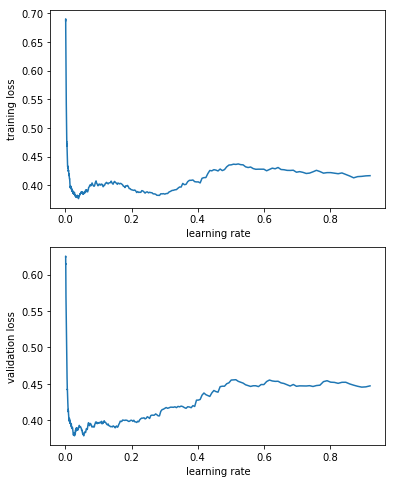

In [277]:
tabular_learner.sched.plot()

In [278]:
lr = 5e-1

In [279]:
tabular_learner.fit(lr, metrics=[roc_auc], n_cycle = 3, cycle_len= 2, use_wd_sched=True, wds=1e-4)

epoch      trn_loss   val_loss   roc_auc                       
    0      0.33476    0.350407   0.74413   
    1      0.344566   0.346297   0.746511                      
    2      0.353912   0.356734   0.747259                      
    3      0.336216   0.352047   0.750609                      
    4      0.359958   0.350288   0.7494                        
    5      0.33707    0.348075   0.753156                      


[array([0.34808]), 0.7531556151827375]